In [1]:
# Kenneth Meyer
# 11/27/22
# CSE383C hw5

In [2]:
import numpy as np

In [3]:
from scipy.linalg import cholesky
from pyamg.gallery import poisson
n = 100
A = poisson((n,n)) # sparse
B = A.toarray() + cholesky(A.toarray()) # asymmetric; dense

tol = 1e-6 # specified in the homework

# 1 : **see written answer**

# 2 : *CG and GMRES*

## 2a: CG relative error

In [4]:
from scipy.sparse.linalg import cg

In [5]:
# initial guess
x0 = np.zeros(n**2)
# true solution
x_ = np.ones(n**2)
# compute b, as we are given the true solution (and not b). A is sparse, should be efficient mult.
b = A @ x_ # just sums of rows; band is 2n + 1.

# define global residual and error vectors to record residual and error in callback function

In [6]:
# callback monitor function to compute relative residual and error at each iteration step

# global variables to record all of this
res = []
err = []
def call_back_cg(xk):
    # xk is the solution at the kth iteration
    
    # compute residual, A and b are known
    res_i = b - A @ xk
    res.append(np.sqrt(res_i.T @ A @ res_i)) # save the A-norm only!
    
    # compute error (solution is known). do I construct new array each time??
    x_ = np.ones(n**2)
    err_i = x_ - xk
    err.append(np.sqrt(err_i.T @ A @ err_i)) # save A-norm
    
    # return residual and error
    #return res,err
# not sure how callback functions work so will be interested to see if this works.

In [7]:
# Solve Ax = b for n=100, x* = 1 (true solution)
sol = cg(A,b,x0=x0, tol=tol,callback=call_back_cg)

In [8]:
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import scipy.optimize as opt

# matplotlib options
mpl.rcParams['figure.figsize'] = [8.0,8.0]
mpl.rcParams['figure.dpi'] = 125
mpl.rcParams['savefig.dpi'] = 600
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

# Setup font labels for 3d plots.
labelfont = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 12,
        }

In [9]:
# plot results using semilogy; create plotting function to make this easy.
def plot_res_err(title, residual, error):
    # do something here
    fig = plt.figure()
    ax = fig.add_subplot()
    xs = np.arange(0,len(residual))
    ax.semilogy(xs,residual)
    ax.semilogy(xs,error)
    ax.legend(['Residual','Error'])
    ax.set_title(title)
    ax.set_xlabel("iterations")
    ax.set_ylabel("A-norm of $r_i$ and $e_i$")
    return fig,ax

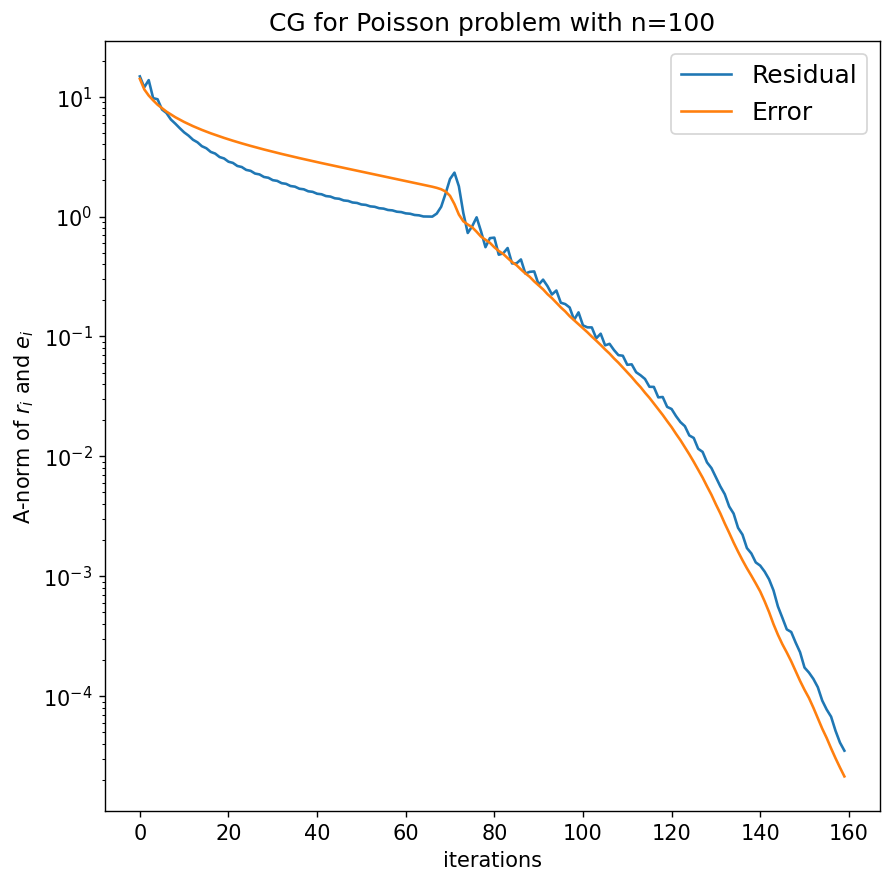

14.747211689526383
number of iterations to converge : 160


In [10]:
fig,ax = plot_res_err("CG for Poisson problem with n=100",res,err)
plt.show()
print(res[0])
print("number of iterations to converge : " + str(len(res)))

## 2a: (results)
As expected, the residual fluctuates throughout the CG solve, and the error is strictly decreasing. A solution (within the given tolerance 1e-6) was reached after 160 iterations. Note that the norm used in the plot (the A-norm) is not the same norm that is used by scipy's CG solver (likely L2 norm), which is why the residual and error are both less than $10^{-8}$ at the final iteration.

## 2b : propose scheme to still use CG (pencil and paper) to still solve system using CG

To still use CG to solve the system $Bx = b$, we must force $B$ to be symmetric. An easy way to do this is to use $B^TB$; for all square matrices $C$, $C^TC$ is guaranteed to be symmetric. Thus, we just need to restate the system of equations as
$$ B^TBx = B^Tb $$
and this can now be solved by CG because it is symmetric. Note that the matrix loses its sparsity, so CG may not be extremely efficient. There is likely a much better way of applying some preconditioner or another matrix multiplication to $B$ because it is the sum of a SPD matrix ($A$) and the cholesky factorization of $A$, but this is the quickest thing that I thought of, and it should work because the matrix we are inputing to the CG solver is symmetric.

In [11]:
# 2b: code and plots

# note that these multiplications take a decent chunk of time when n=100; sparsity is lost because of the method I chose :(
n_50 = 50
A_50 = poisson((n_50,n_50)) # sparse
B_50 = A_50.toarray() + cholesky(A_50.toarray())

x0_b = np.zeros(n_50**2) # initial guess
x_b = np.ones(n_50**2) # actual solution
b_50 = B_50 @ x_b # determine b for the system Bx=b

# define the matrix and array to pass to scipy's CG (and GMRES) functions for the system B^TBx = B^Tb
BB_50 = B_50.T @ B_50
Bb_50 = B_50.T @ b_50
print(B_50.shape)
print(b_50.shape)
print(x0_b.shape)

(2500, 2500)
(2500,)
(2500,)


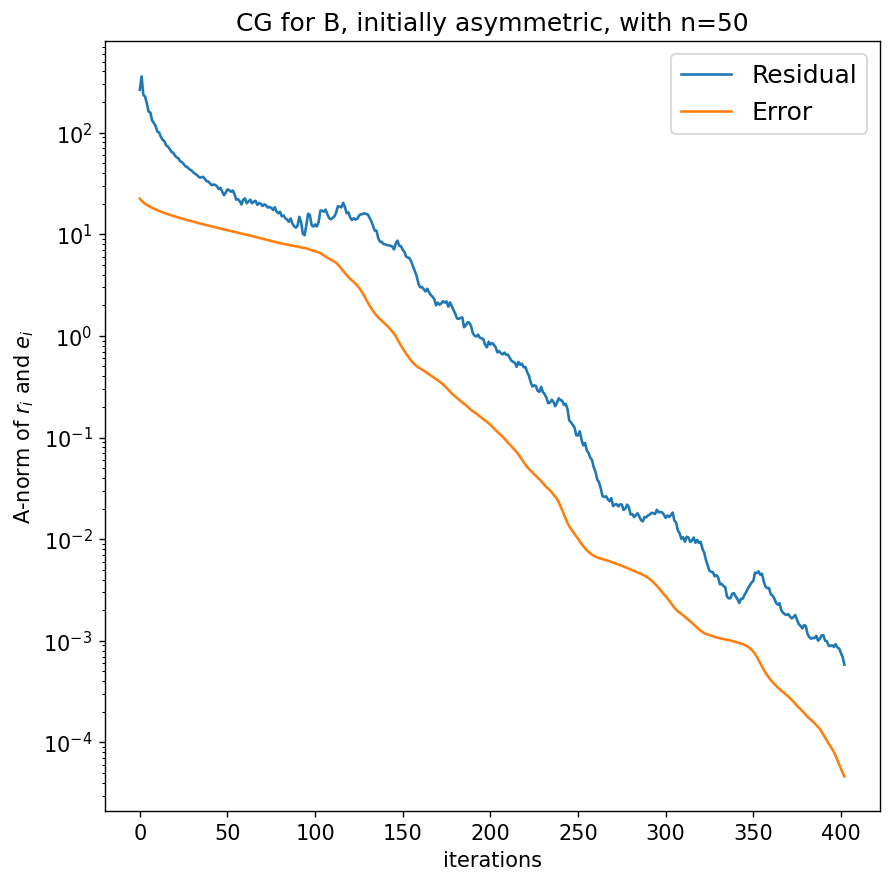

In [12]:
# solve using CG

# define a new callback function because the old one might use global variables A and b?...
def call_back_B(xk):
    # xk is the solution at the kth iteration
    
    # compute residual, A and b are known
    res_i = Bb_50 - BB_50 @ xk
    res.append(np.sqrt(res_i.T @ BB_50 @ res_i)) # save the A-norm only!
    
    # compute error (solution is known). do I construct new array each time??
    x_ = np.ones(n_50**2)
    err_i = x_ - xk
    err.append(np.sqrt(err_i.T @ B_50 @ err_i)) # save A-norm

# clear the residual and error global variables
res = []
err = []

# call cg method using callback function
sol = cg(BB_50,Bb_50,x0=x0_b, tol=tol,callback=call_back_B)

# plot the residual and error
fig,ax = plot_res_err("CG for B, initially asymmetric, with n=50",res,err)
plt.show()

In [13]:
print("Number of iterations: " + str(len(res)))

Number of iterations: 403


## 2b: discussion
Clearly, performance is "worse" with the matrix B as it took 403 iterations to solve a 2500 by 2500 system vs. 160 iterations to solve the 10000 by 10000 system presented in 2a. This is expected as B is not a sparse matrix, it has 25000^2 nonzero entries, while A has a maximum of 5 nonzero entries per row if the full bandwith if A is expressed.

## 2c : same thing except use GMRES (without restart) to solve the system.

In [14]:
# import scipy's gmres solver
from scipy.sparse.linalg import gmres

In [15]:
# the same callback function can be used!

# resetting the global variables used in the callback function
res = []
err = []
# solution for n = 100 with the matrix A : 
sol_gmres = gmres(A,b,x0=x0,tol=tol,callback=call_back_cg, callback_type='x')

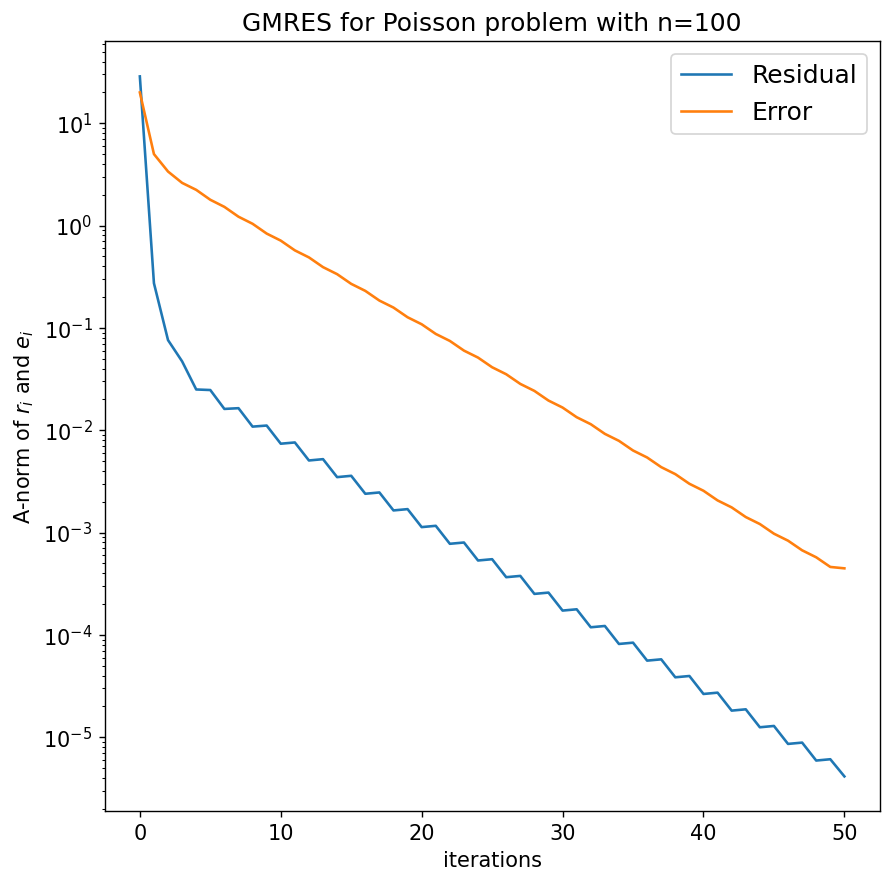

In [16]:
fig,ax = plot_res_err("GMRES for Poisson problem with n=100",res,err) 

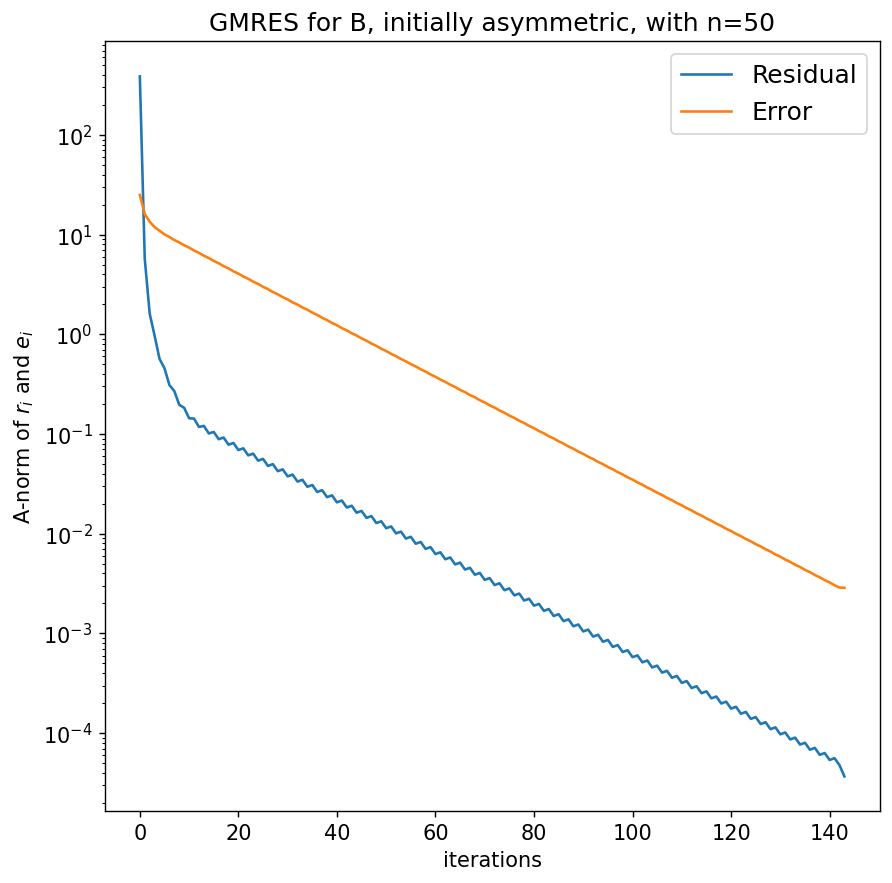

Number of iterations: 144


In [17]:
# GMRES for B^Bx = B^b

# clear the residual and error global variables
res = []
err = []

# call cg method using callback function
sol = gmres(BB_50,Bb_50,x0=x0_b, tol=tol,callback=call_back_B,callback_type='x')

# plot the residual and error
fig,ax = plot_res_err("GMRES for B, initially asymmetric, with n=50",res,err)
plt.show()

print("Number of iterations: " + str(len(res)))

## 2c : Discussion
Solving $Ax=b$ : As expected, the residual for GMRES fluctuates but decreases at a more logarithmic (which appears linear on the plot) rate and it is significantly less than the error, which is again only decreasing. It converges in fewer iterations for a sparse, $n^2$ by $n^2$ 2D Laplacian matrix (51) than it took for CG to converge (160).
$$ $$ Solving $Bx=b$ (really solving $B^TBx = B^Tb$) : Similar to the behavior seen when solving the system $Ax=b$, GMRES performs better than CG does and its residual decreases more linearly after an initial sharp descent in the first few iterations. It took (144) iterations to converge.

# 3. CG, Characteristic Polynomial

In [18]:
# A mxm SPD, b of length m.

In [19]:
# confusions:
# 1. CG implicitly finds the coefficients of the polynomial p_k(z) that minimizes the error...
#      ^ is there a way to extract this implicit computation without using computed eigenvalues of A? seems like computing eigenvalues is defeating the purpose...

## 3a: description of algorithm **(with equations)** used to compute coefficients of the polynomial $p_k(z)$ that is implicitly computed by CG for solving Ax=b after x iterations using a zero initial guess

To compute the polynomial $p_k(z)$ that is implicitly computed by CG for solving $Ax=b$, we can perform an eigendecomposition of the matrix $A$ after a solution is reached to find the coefficients used to generate the polynomial that is implicity computed by CG. It is clear that the eigendecomposition of $A$ is intended to be used as we are given $A$ as a diagonal matrix so its eigenvalues are its diagonal entries, and we are solving a system with evenly spaced eigenvalues in part (b) and clustered eigenvalues in part (c). Below is a basic description of the algorithm:
1. Find solution to $Ax=b$ using CG, saving error at each iteration using a callback function
2. Compute eigenvalues of $A$
3. For i = 1,...,10, fit a polynomial to 0 = sum($\delta_i\lambda_{i}^{j}$) (**check equation**)
4. save coefficients and plot polynomials for each degree

In [20]:
n = 10
A = np.zeros((n,n))
for i in range(0,10):
    A[i,i] = i+1

In [21]:
# initial guess and esact solution:
x0 = np.zeros(n) # initial guess
x_ = np.ones(n) # exact solution
b = A @ x_ # determines b

In [22]:
# new callback function because some variables changed slightly
x_i = []
def call_back_cg3(xk):
    # xk is the solution at the kth iteration
    x_i.append(xk)
    # compute residual, A and b are known
    res_i = b - A @ xk
    res.append(np.sqrt(res_i.T @ A @ res_i)) # save the A-norm
    
    #res.append(np.linalg.norm(res_i,2)) # weird behavior is observed when using A-norm... (was caused by running cells out of order I think)
    
    # compute error (solution is known). do I construct new array each time??
    x_ = np.ones(n)
    err_i = x_ - xk
    err.append(np.sqrt(err_i.T @ A @ err_i)) # save A-norm
    #err.append(np.linalg.norm(err_i,2))

In [23]:
# apply CG, using callback function, and record error and residual.
res = []
err = []
sol = cg(A,b,x0=x0, tol=tol,callback=call_back_cg3)

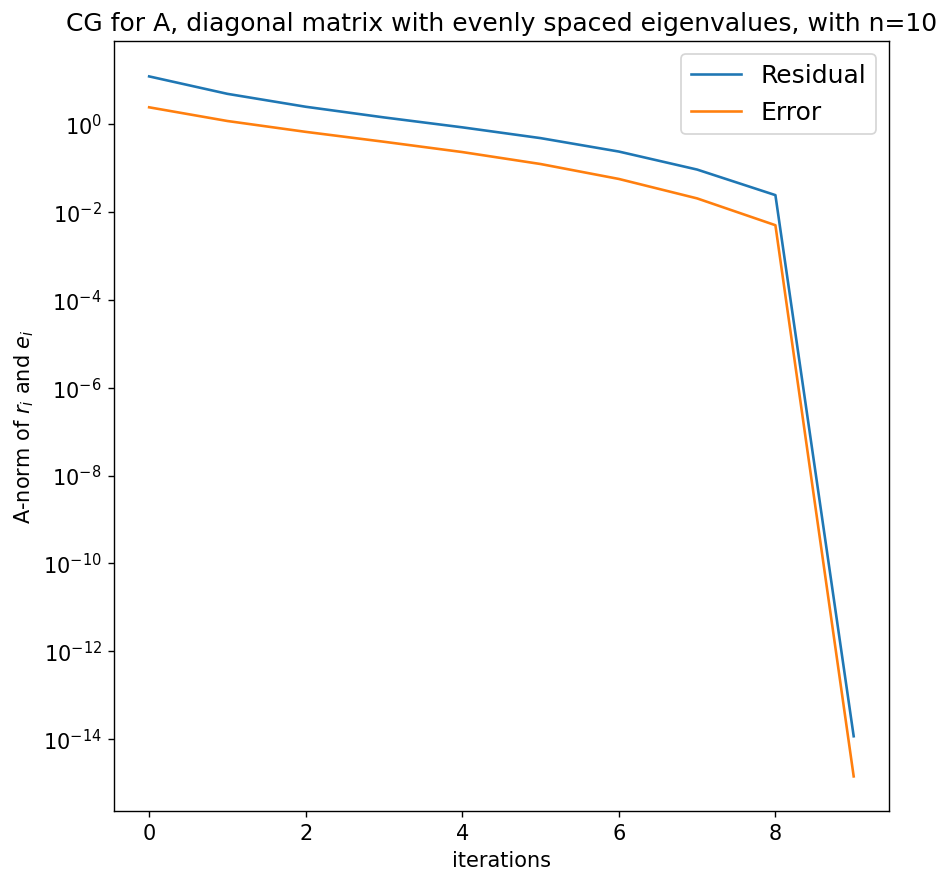

Number of iterations: 10


In [24]:
# plot the residual and error
fig,ax = plot_res_err("CG for A, diagonal matrix with evenly spaced eigenvalues, with n=10",res,err)
plt.show()

print("Number of iterations: " + str(len(res)))

/tmp/ipykernel_1732357/391744613.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xsolls = np.linalg.lstsq(x1,x_i[k-1])[0]


Text(0.5, 1.0, 'Plotting polynomials for k = 1,...,10')

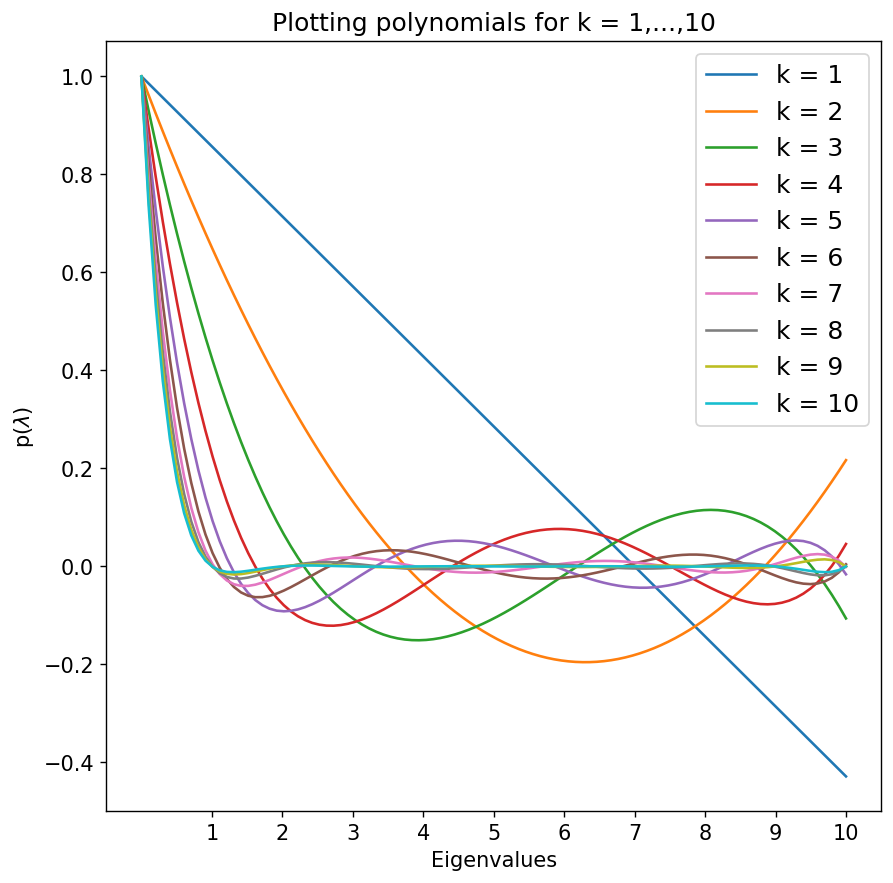

In [25]:
# plotting polynomials for k = 1,...,10

# find the coefficients given a matrix A and solutions at each iteration xk, using krylov subspace.
def find_coeff(A,xk,i):
    # A = matrix
    # xk = list of solutions at each iteration
    # i = number of iterations it took to converge
    
    coeff = []
    e0 = -np.ones(A.shape[0])
    
    for k in range(1,i+1):
        A_temp = A
        x1 = np.zeros((A.shape[0],k))
        x_i[k-1] = x_i[k-1].reshape(x_i[k-1].shape[0],1) 
        for ii in range(k):
            x1[:,ii] = A_temp @ e0
            A_temp = A_temp @ A
            xsolls = np.linalg.lstsq(x1,x_i[k-1])[0]
            
        coeff.append(np.flip(xsolls))
    
    # adds p(0) = 1 ??
    for x in range(len(coeff)):
        if x==0:
            coeff[x] = np.append(coeff[x],1)
            continue
        coeff[x] = np.append(coeff[x].squeeze(),1)

    return coeff

A_eig,A_eigvec = np.linalg.eig(A)

# plot the different curves
x = np.linspace(0,10,100)
fig = plt.figure()
ax = fig.add_subplot()

# x_i is defined in the callback function
xval = find_coeff(A,x_i,len(res))
for i in range(len(xval)): 
    curve = np.array(xval[i])
    y = [np.polyval(curve,i) for i in x]
    plt.plot(x,y,label = f'k = {i+1}')
    plt.legend()
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("p($\lambda$)")
ax.set_xticks(A_eig)
ax.set_title("Plotting polynomials for k = 1,...,10")

In [26]:
## plotting the error as determined by the energy norm of the ith iteration
def compute_approx_polynorm(error):
    
    poly_norm_estimate = []
    
    # error is already given as a norm.
    for i in range(0,len(error)):
        poly_norm_estimate.append(error[i]/error[0])
        
    return poly_norm_estimate

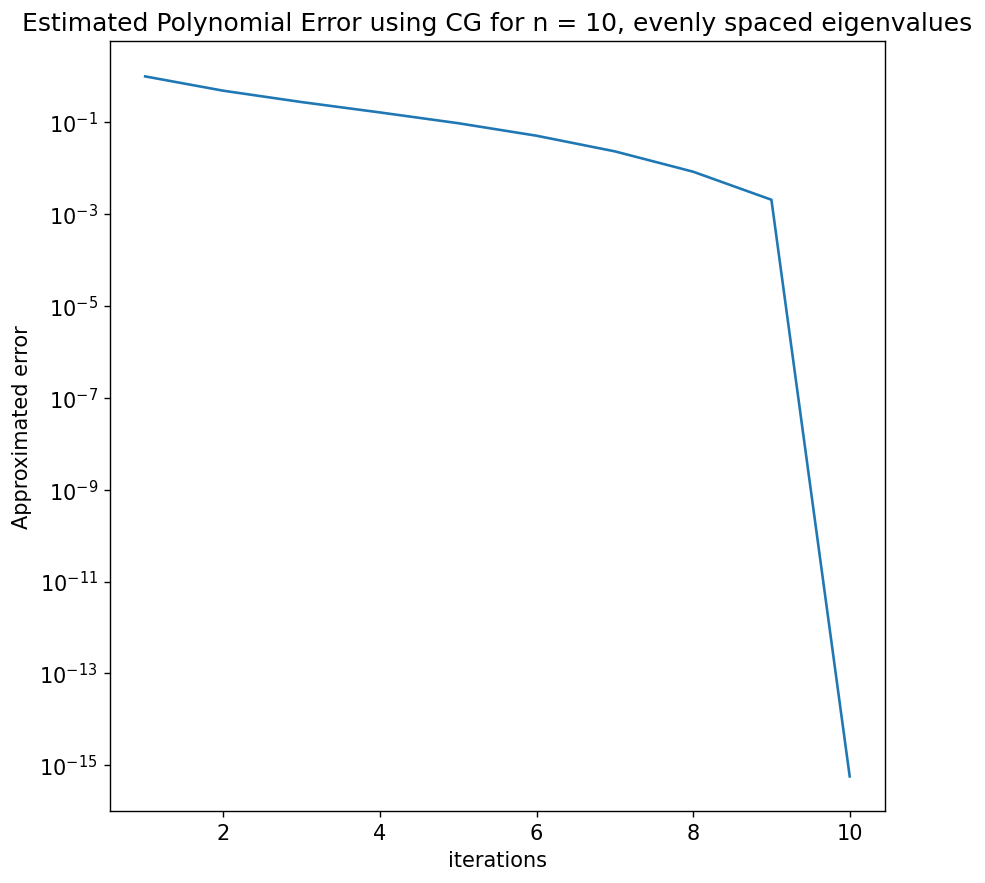

In [27]:
# compute and plot the approximated polynomial norm
poly_norm_cg = compute_approx_polynorm(err)
iterations = np.arange(1,len(err)+1)
fig = plt.figure()
ax = fig.add_subplot()
ax.semilogy(iterations,poly_norm_cg)
ax.set_title("Estimated Polynomial Error using CG for n = 10, evenly spaced eigenvalues")
ax.set_xlabel("iterations")
ax.set_ylabel("Approximated error")
plt.show()

In [28]:
# norm of the polynomial - see lecture 21!
# uses p(lambda)

# something is wrong here, error is blowing up!
# think I am approaching this incorrectly, I think I'm supposed to always look at max eigenvalue?...not really worth my time.
def eig_powers(eig,i):
    eig_n = np.zeros(i)
    
    for jj in range(1,i):
        eig_n[jj-1] = eig**jj
        
    return eig_n

def poly_norm(A,i,coeff,eig):
    # returns L2 norm of the polynomial of the matrix A at a given iteration i with known coefficients
    
    k = eig.shape[0] # k eigenvalues for the matrix A
    vals = np.zeros(k)
    
    # lambda function to evaluate the polynomial at the eigenvalues!
    p = lambda lam_k,coeffs : np.abs(1 - np.dot(coeffs, lam_k))
    
    # for each eigenvalue, compute the error!
    for ii in range(1,k):
        # lam_n is an array of the kth eigenvalue raised to the 1 - ith powers
        #print(ii)
        lam_n = eig_powers(eig[ii],i)
        #print(lam_n)
        #print(coeff[-1*ii][0:ii])
        #print(np.flip(coeff[i-1])[1:])
        
        vals[ii] = p(lam_n,np.flip(coeff[i-1])[1:]) # coefficients are sorted backwards, ignore the last coefficient (1) which gets flipped to the front.
    print(vals)
    l2_norm = vals.max()
    return l2_norm

def poly_norm_l2(xval,eig):
    # just computes the l2 norm at each of the eigenvalues, should decrease with each iteration.
    poly_errors = np.zeros(len(eig))
    for i in range(len(xval)): 
        curve = np.array(xval[i])
        # evaluate the polynomial at each eigenvalue
        ys = [np.polyval(curve,i) for i in eig]
        #poly_errors[i] = np.sum(np.abs(ys)) # should all be zero
        poly_errors[i] = np.linalg.norm(ys)
    return poly_errors
        


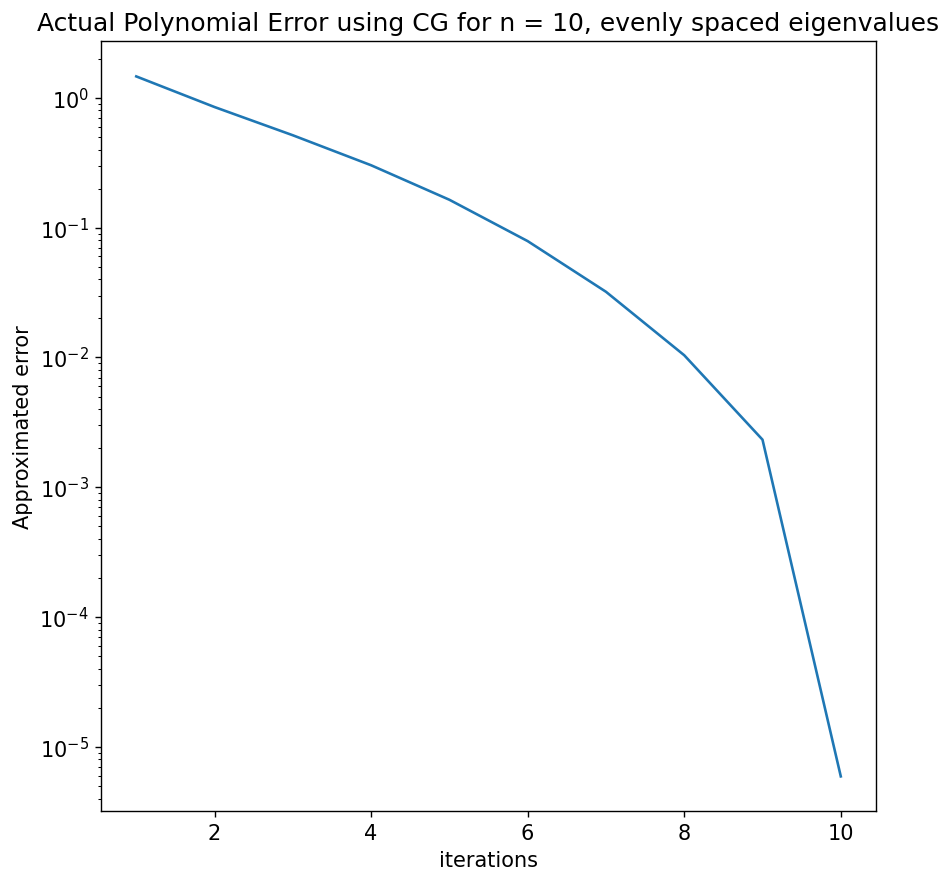

In [29]:
# plotting the norm of the polynomial with each iteration
coefficients = xval
iterations = np.arange(1,len(res)+1)
norms = np.zeros(len(res))

#for ii in range(1,len(res)):
    #print(ii)
    #norms[ii] = poly_norm(A,ii,coefficients,A_eig)

norms = poly_norm_l2(xval,A_eig)
fig = plt.figure()
ax = fig.add_subplot()
ax.semilogy(iterations,norms)
ax.set_title("Actual Polynomial Error using CG for n = 10, evenly spaced eigenvalues")
ax.set_xlabel("iterations")
ax.set_ylabel("Approximated error")
plt.show()

In [30]:
# plotting the norm of the polynomials using the definition ||p(A)|| <= ||e(i+1)||/||e(i)||

## 3b: discussion
*discuss results here*

## 3c. Repeating 3b, for $A$ 30 by 30 diagonal matrix with clustered eigenvalues of 1, 10, and 20.

In [31]:
n = 30
A = np.zeros((n,n))

In [32]:
# populating AA
for i in range(0,n):
    if i < 10:
        A[i,i] = 1
    elif i < 20:
        A[i,i] = 10
    elif i < 30:
        A[i,i] = 20
    
# initial guess and esact solution:
x0 = np.zeros(n) # initial guess
x_ = np.ones(n) # exact solution
b = A @ x_ # determines b

In [33]:
res = []
err = []
x_i = []
# new callback function because some variables changed slightly
def call_back_cg3_test(xk):
    # xk is the solution at the kth iteration
    x_i.append(xk)
    # compute residual, A and b are known
    res_i = b - A @ xk
    res.append(np.sqrt(res_i.T @ A @ res_i)) # save the A-norm
    
    #res.append(np.linalg.norm(res_i,2)) # weird behavior is observed when using A-norm... (was caused by running cells out of order I think)
    
    # compute error (solution is known). do I construct new array each time??
    x_ = np.ones(n)
    err_i = x_ - xk
    err.append(np.sqrt(err_i.T @ A @ err_i)) # save A-norm
    #err.append(np.linalg.norm(err_i,2))

# forgot to reset the residual...
#res = []
#err = []
sol30 = cg(A,b,x0=x0, tol=tol,callback=call_back_cg3_test)

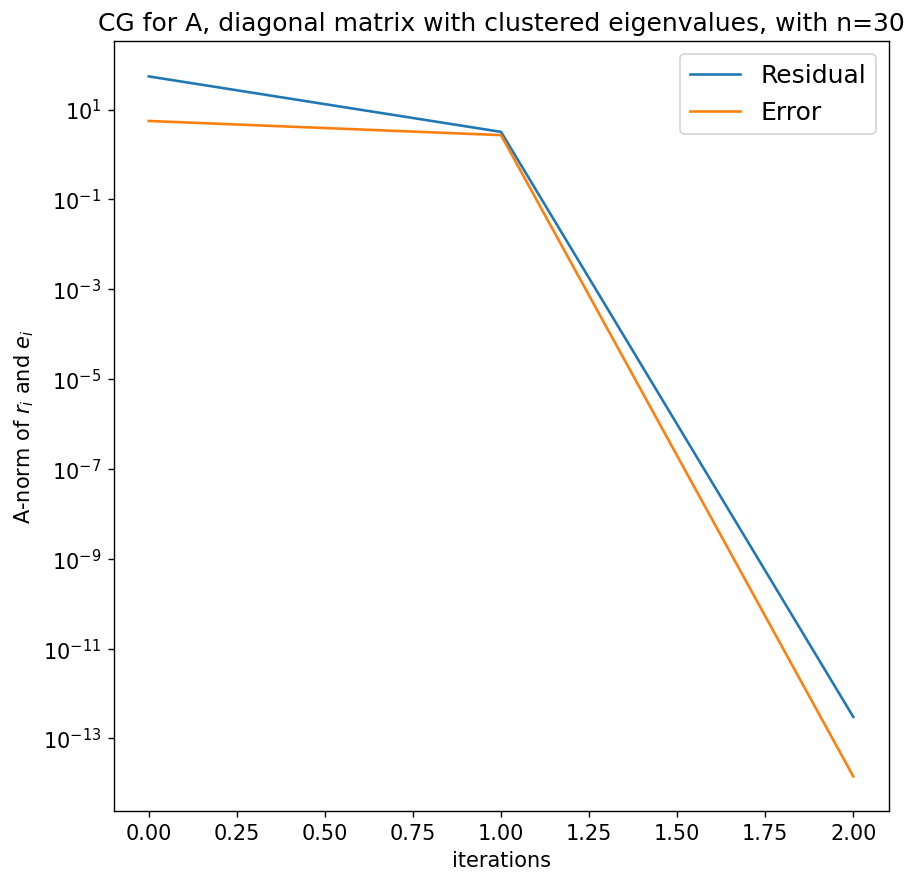

Number of iterations: 3


In [34]:
fig,ax = plot_res_err("CG for A, diagonal matrix with clustered eigenvalues, with n=30",res,err)
plt.show()

print("Number of iterations: " + str(len(res)))

/tmp/ipykernel_1732357/391744613.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xsolls = np.linalg.lstsq(x1,x_i[k-1])[0]


Text(0.5, 1.0, 'Plotting polynomials for A with clustered eigenvalues')

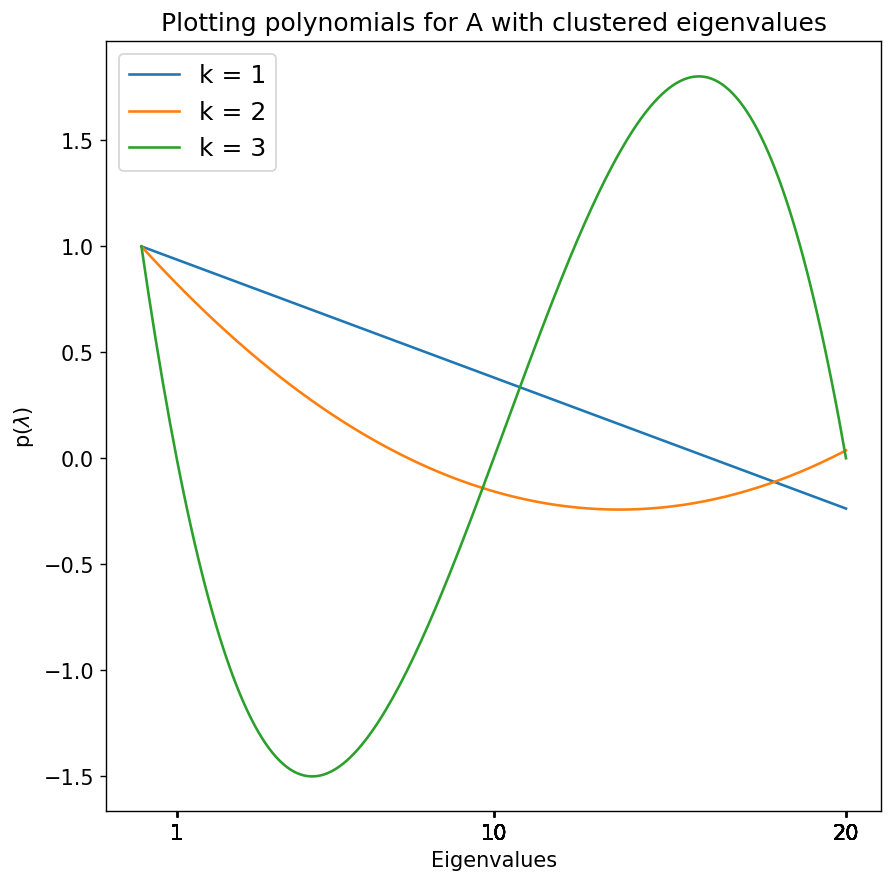

In [35]:
# plot the polynomials that are being computed!
A_eig,A_eigvec = np.linalg.eig(A)

# plot the different curves
x = np.linspace(0,20,200)
fig = plt.figure()
ax = fig.add_subplot()

# x_i is defined in the callback function
xval = find_coeff(A,x_i,len(res))
for i in range(len(xval)): 
    curve = np.array(xval[i])
    y = [np.polyval(curve,i) for i in x]
    plt.plot(x,y,label = f'k = {i+1}')
    plt.legend()
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("p($\lambda$)")
ax.set_xticks(A_eig)
ax.set_title("Plotting polynomials for A with clustered eigenvalues")

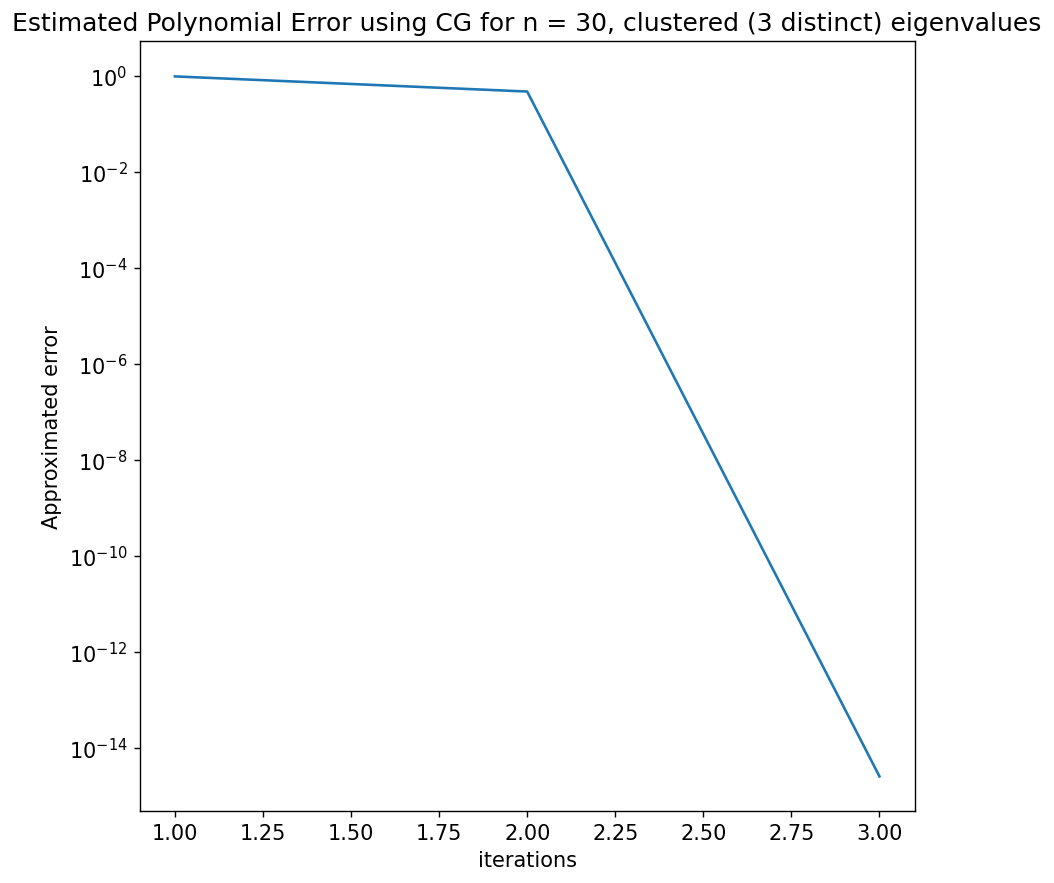

In [36]:
# compute and plot the approximated polynomial norm
poly_norm_cg = compute_approx_polynorm(err)
iterations = np.arange(1,len(err)+1)
fig = plt.figure()
ax = fig.add_subplot()
ax.semilogy(iterations,poly_norm_cg)
ax.set_title("Estimated Polynomial Error using CG for n = 30, clustered (3 distinct) eigenvalues")
ax.set_xlabel("iterations")
ax.set_ylabel("Approximated error")
plt.show()

(array([0, 1, 2]),)


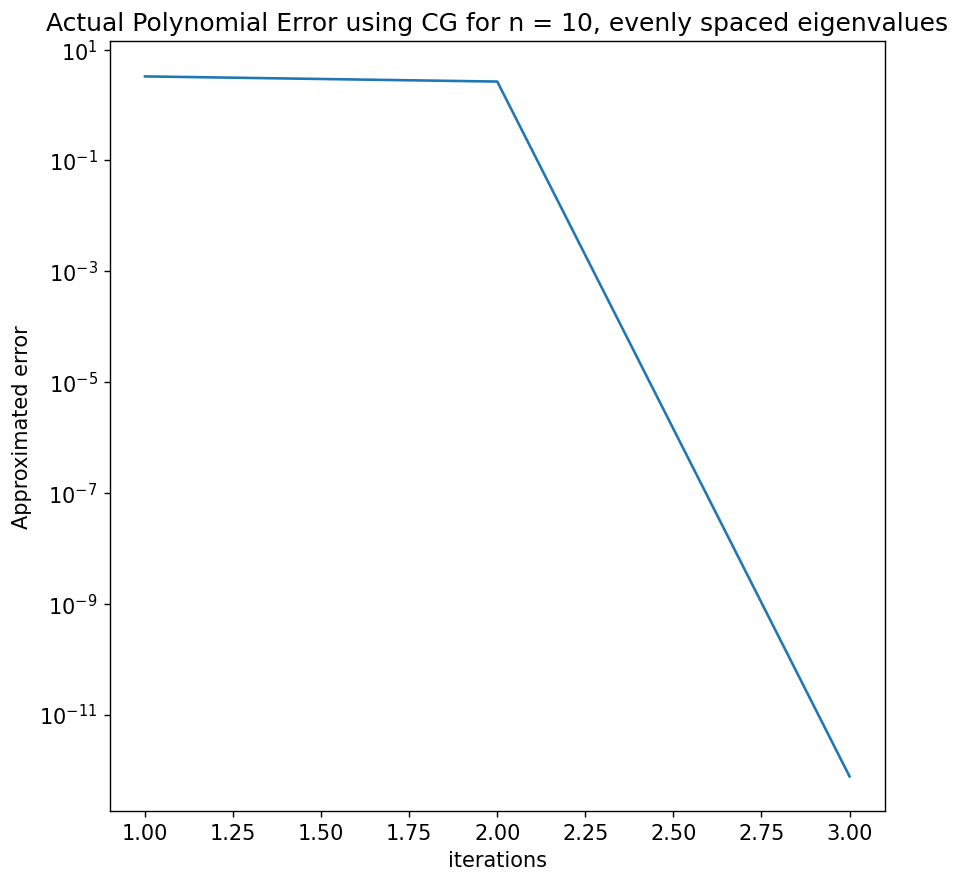

In [37]:
# plotting the norm of the polynomial with each iteration
coefficients = xval
iterations = np.arange(1,len(res)+1)
norms = np.zeros(len(res))

#for ii in range(1,len(res)):
    #print(ii)
    #norms[ii] = poly_norm(A,ii,coefficients,A_eig)

norms = poly_norm_l2(xval,A_eig)
print(np.nonzero(norms))
fig = plt.figure()
ax = fig.add_subplot()
ax.semilogy(iterations,norms[np.nonzero(norms)])
ax.set_title("Actual Polynomial Error using CG for n = 10, evenly spaced eigenvalues")
ax.set_xlabel("iterations")
ax.set_ylabel("Approximated error")
plt.show()

## 3c. Discussion of results
As seen in the graph above, the eigenvalues are computed exactly with a polynomial of degree 3, as there are exactly 3 distinct eigenvalues (0, 10, and 20) in this system. Additionally, CG converged in 3 iterations, which makes sense for the same reason. This result, along with the reusult in 3b, shows that convergence is significantly faster for systems with clustered eigenvalues vs. systems with evenly spaced eigenvalues. In fact, as discussed in the "CG krylov subspaces without the agonizing pain" notes, SPD matricies A that present a worst-case scenario for CG solvers are matrices with evenly spaced eigenvalues. This is proven by the convergence demonstrated in these two cases, as it took the matrix in A a FULL 10 iterations to converge (A was 10 by 10, this was the maximum number of iterations possible with CG!) and only 3 iterations were required for a larger (30 by 30) system in 3c.

Note that the polynomial norm calculated from the error bound determined by the energy norms of the error of the current iteration of CG and the first CG iteration does not always seem to be greater than the polynomial norm that was calculated to be the exact polynomial norm; there could be a small bug in my code, error introduced in computing the coefficients using polyval since it is a polynomial fitting method and does not actually extract the exact polynomials used in CG that are generated when the error is minimized in each CG iteration, or I could be using the wrong definition of error.

In [38]:
# moral of the story - with clustered eigenvalues, we converge to a solution before the end of CG!
# ^ with evenly spaced eigenvalues, 

# this is also why the residual was chosen to be 1e-6, because the standard tolerance of 1e-5 would have caused termination of CG at an earlier step!!!!!!

In [39]:
# is the number of iterations supposed to be equal to the number of unique eigenvalues? check this. (YES)

In [40]:
# should only be 3 iterations; polynomial only has 3 zeros!!

In [41]:
# 5:22pm - leaving this for tomorrow after the exam; need to study/it's not worth it to find some marginal part of the homework right now.
# ^ only need to figure out how to compute the exact error of the polynomial fit at each step and then I am done; this is a small part.